## Variational Auto-Encoder

   > [*Auto-Encoding Variational Bayes*, D. Kingma, M. Welling, ICLR 2017](https://arxiv.org/abs/1312.6114)

In [6]:
import os
import glob
from datetime import datetime

import numpy as np
import scipy.misc
import tensorflow as tf
import tensorflow.contrib.slim as slim

import logging
logging.getLogger("tensorflow").setLevel(logging.WARNING)

First, we define the input loading queue which reads images from a given list of filenames and feed them through an optional preprocessing function.

The `get_inputs_queue` function returns a queue whose elements are input dictionnary with keys:
  * `image`: A 4D Tensor of size (BATCH_SIZE, HEIGHT, WIDTH, N_CHANNELS) representing the input images.
  
The `preprocess_inputs` function simply performs a central crop on the input image, resize them to 128x128 and finally maps them to [-1, 1].

In [7]:
def get_inputs_queue(filenames, 
                     preprocess_inputs=None,
                     batch_size=32,
                     num_threads=5,
                     extension='jpg', 
                     channels=3,
                     capacity=800,
                     min_after_dequeue=100):
    """Returns a queue containing the inputs batches read from a list of files.
    
    Args:
      filenames: List of image files to read the input from.
      preprocess_inputs: Preprocessing function taking a dictionary as input 
        and outputting a dictionnary with the same keys.
      batch_size: Batch size.
      num_threads: Number of readers for the batch queue.
      extension: Image format.
      channels: Number of image channels.
      capacity: Queue capacity.
      min_after_dequeue: Min_after_dequeue parameter for the shuffle queue.
      
    Returns: 
      A queue containing the input batches, where each input is a dictionnary
      of Tensors.
    """
    inputs = {}    
    # Read Image
    filename_queue = tf.train.string_input_producer(
        filenames, capacity=capacity, shuffle=False)
    _, reader = tf.WholeFileReader().read(filename_queue)
    if extension in ['jpg', 'jpeg']:
        image = tf.image.decode_jpeg(reader, channels=channels, name='decoder')
        inputs['image'] = image
    else:
        raise ValueError('%s unimplemented' % extension)
        
    # Preprocess the inputs
    if preprocess_inputs is not None:
        input_keys = sorted(list(inputs.keys()))
        with tf.variable_scope('inputs_preprocess'):
            inputs = preprocess_inputs(inputs)
        assert sorted(list(inputs.keys())) == input_keys
    
    # Batch the inputs 
    inputs = tf.train.shuffle_batch(inputs, 
                                    batch_size, 
                                    capacity, 
                                    min_after_dequeue,
                                    num_threads=num_threads, 
                                    name='inputs_batches_queue')
    return inputs   

def preprocess_inputs(inputs, tight_crop=False, size=256):
    """Preprocess input images to map them to [0, 1] and square-resize them.
    
    Args:
      inputs: A dictionnary of Tensors.
      tight_crop: If True, the input face is further cropped.
      size: The square size to resize image to.
      
    Returns:
      The preprocessed dictionnary of inputs with normalized images.
    """
    # Map to [-1, 1]
    with tf.control_dependencies([tf.assert_type(inputs['image'], tf.uint8)]):
        inputs['image'] = tf.image.convert_image_dtype(
            inputs['image'], tf.float32)
        inputs['image'] = (inputs['image'] - 0.5) * 2
        
    # Central crop to minimal side
    height = tf.shape(inputs['image'])[0]
    width = tf.shape(inputs['image'])[1]
    min_side = 108 if tight_crop else tf.minimum(height, width)
    offset_height = (height - min_side) // 2
    offset_width = (width - min_side) // 2
    inputs['image'] = tf.image.crop_to_bounding_box(
        inputs['image'], offset_height, offset_width, min_side, min_side)
    
    # Resize
    if size is not None and size > 0:
        inputs['image'] = tf.image.resize_images(inputs['image'], (size, size))
    
    return inputs

Next, we define the main architecture of the auto-encoder structure as follows:

#### Encoder

  * *Inputs*: (batch size**x**128**x**128**x**3) in [-1, 1]
  * 5 convolutional blocks
    * Convolutions, stride 2
    * ReLU activation and Batch normalization
    * Max-pooling
  * Final block: (batch size**x**4**x**4**x**c)
  * 2 separate fully-connected layers
  * *Outputs*: mean and log variance of the latent code, each (batch size**x**num_latent_dims)
  
#### Decoder

  * *Inputs*: (batch size**x**num_latent_dims)
  * 1 deconvolution upscale the input to (batch size**x**4**x**4**x**c)
  * 5 deconvolutional blocks
    * transpose convolution, stride 2
    * ReLU activation and Batch normalization
  * *Outputs*: (batch size**x**128**x**128**x**3) in [-1, 1], mean of the image distribution

In [8]:
def encoder(inputs, 
            num_filters, 
            num_dims,
            kernel_size=5,
            activation_fn=tf.nn.relu, 
            normalizer_fn=slim.batch_norm,
            normalizer_decay=0.99,
            is_training=True, 
            reuse=False):
    """Simple convolutional encoder with ReLU, batch norm and max-pool.
    
    Args:
      inputs: 4D Tensor of images.
      num_filters: Number of filters for each convolutional block.
      num_dims: Number of dimensions of the output latent representation.
      activation_fn: Activation function. Defaults to elu.
      normalizer_fn: Normalization function. Defaults to Batch norm. Set to
          None for no normalization.
      normalizer_decay: Decay for the normalization.
      is_training: Whether the model is in training mode.
      reuse: Whether to reuse the variables or not.
      
    Returns:
      Two 2D Tensor representing the mean and variance of the latent normal distribution
    """
    assert(len(num_filters) > 0 and num_dims > 0)
    # Config
    weights_initializer = tf.contrib.layers.xavier_initializer()
    normalizer_params = {'is_training': is_training, 'decay': normalizer_decay}
    
    # Network
    with tf.variable_scope('encoder', reuse=reuse):
        # Convolutions
        with slim.arg_scope([slim.conv2d],
                            stride=2,
                            weights_initializer=weights_initializer,
                            activation_fn=activation_fn,
                            normalizer_fn=normalizer_fn,
                            normalizer_params=normalizer_params,
                            padding='SAME'):
            net = inputs
            for i, num_filter in enumerate(num_filters):
                net = slim.conv2d(net, num_filter, [kernel_size, kernel_size],
                                  scope='conv%d' % (i + 1))
                
        # Fully connected
        assert net.get_shape()[1].value == 4
        assert net.get_shape()[2].value == 4
        net = tf.contrib.layers.flatten(net)
        
        with slim.arg_scope([slim.fully_connected],
                            weights_initializer=weights_initializer,
                            normalizer_fn=None,
                            activation_fn=None):
            z_mean = slim.fully_connected(net, num_dims)
            z_log_var = slim.fully_connected(net, num_dims)
            
        return z_mean, z_log_var
    
def decoder(latent_z, 
            num_filters,
            kernel_size=5,
            activation_fn=tf.nn.relu, 
            normalizer_fn=slim.batch_norm,
            normalizer_decay=0.99,
            is_training=True, 
            reuse=False):
    """ Simple convolutional decoder with deconvolutions and ReLU.
    
    Args:
      latent_z: 2D Tensor representing the latent variable.
      num_filters: Number of filters for each deconvolutional block.
      activation_fn: Activation function. Defaults to elu.
      normalizer_fn: Normalization function. Defaults to Batch norm. Set to
          None for no normalization.
      normalizer_decay: Decay for the normalization.
      is_training: Whether the model is in training mode.
      reuse: Whether to reuse the variables or not.
      
    Returns:
      A 4D Tensor representing the output images in [-1, 1]
      
    """
    # Config
    weights_initializer = tf.contrib.layers.xavier_initializer()
    normalizer_params = {'is_training': is_training, 'decay': normalizer_decay}
    
    # Network
    with tf.variable_scope('decoder', reuse=reuse):
        with slim.arg_scope([slim.conv2d_transpose], stride=2,
                            weights_initializer=weights_initializer,
                            activation_fn=activation_fn,
                            normalizer_fn=normalizer_fn,
                            normalizer_params=normalizer_params,
                            padding='SAME'):
            # Flattened input -> 4 x 4 patch
            shape = latent_z.get_shape().as_list()
            net = tf.reshape(latent_z, (shape[0], 1, 1, shape[1]))
            net = slim.conv2d_transpose(net, num_filters[0], [4, 4], stride=1,
                                        padding='VALID', 
                                        scope='deconv1')
            # Upscale via deconvolutions
            for i, num_filter in enumerate(num_filters[1:]):
                net = slim.conv2d_transpose(net, num_filter, [kernel_size, kernel_size],
                                            scope='deconv%d' % (i + 2))
            
            # Final deconvolution
            net = slim.conv2d_transpose(net, 3, [3, 3], 
                                        stride=2,
                                        activation_fn=tf.nn.tanh,
                                        normalizer_fn=None,
                                        scope='deconv_out')
            return net    

The VAE objective is typically decomposed in two terms:
  * The **pixel loss**, which is the expectation of the decoder output under the latent codes distribution generated by the encoder
  \begin{align}
  \mathcal{L}_{pixel}(X, \hat{X}) = \frac{1}{w \times h} \sum_{i=1}^w \sum_{j=1}^h \left( X_{i,j} - \hat{X}_{i, j} \right)**2
  \end{align}
  * The **latent loss**, which is the KL-divergence between the encoder distribution $q(z\ |\ x)$ (Gaussian with diagonal covariance matrix) and the prior $p(z) = \mathcal{N}(0, 1)$
  \begin{align}  
  \mathcal{L}_{latent}(\mu, \sigma) = 0.5 \left( \mu^2 + \sigma - \log(\sigma) - 1 \right)
  \end{align}

In [9]:
def get_pixel_loss(images, reconstructions, weight=1.0):
    """Returns the VAE pixel loss
    
    Args:
        images: Input images
        reconstructions: Generated reconstructions
    """
    return weight * tf.reduce_mean(tf.square(images - reconstructions))

def get_latent_loss(z_mean, z_log_var, weight=1.0):
    """Returns the VAE latent loss for a N(0, 1) latent distribution.
    
    Args:
      z_mean: Estimated means for the latent Gaussian distribution.
      z_log_var: Log of the estimated variances for the latent distribution.
      weight: Optional loss weight.
      
    Returns:
      The latent loss in the VAE objective.      
    """
    return weight * 0.5 * tf.reduce_mean(
        tf.reduce_sum(tf.square(z_mean) + tf.exp(z_log_var) - z_log_var - 1., axis=1))

Finally, we define a few utilitaries function for Tensorboard summaries. The main VAE summaries contain the image reconstructions, sample generations and scalar summary for losses.

Additionally, we define a text summary which contains the configuration of the current run and will only be updated infrequently.

In [10]:
def image_grid(images, num_rows=4, crop=True):
    """Stack images into a square grid with the given number of rows.
    
    Args:
      images: 4D Tensor of images.
      num_rows: Number of rows in the grid.
      crop: If True, trim the first axis so it only contains num_rows**2 images.
    """
    if crop: 
        images = images[:num_rows*num_rows]
    images = images * 0.5 + 0.5
    images = tf.unstack(images, axis=0) 
    images = tf.concat(images, axis=1) 
    images = tf.split(images, num_rows, axis=1) 
    images = tf.concat(images, axis=0) 
    return tf.expand_dims(images, 0)

def comparison_image_grid(images, reconstructions, side=4):
    """Stack images into a square grid arranged for column-wise comparison.
    
    Args:
      images: 4D Tensor of images.
      reconstructions: Another 4D Tensor of images.
      side: Number of rows in the output grid (number of columns will be twice
        that amount).
    """
    out = tf.concat([images[:side * side, ...], 
                     reconstructions[:side * side, ...]], 1)
    width = images.get_shape()[2].value
    out = tf.reshape(out, (2 * side * side, -1, width, 3))
    out = image_grid(out, num_rows=side, crop=False)
    return out

def add_vae_summaries(inputs, outputs, num_rows=4, key='vae'):
    """Additional VAE summaries."""    
    outputs['reconstruction_grid'] = comparison_image_grid(
            inputs['image'], outputs['reconstruction'], side=num_rows)
    tf.summary.image('reconstruction', outputs['reconstruction_grid'], collections=[key])
    
    outputs['sampled_grid'] = image_grid(outputs['sampled'], num_rows=num_rows)
    tf.summary.image('sampled', outputs['sampled_grid'], collections=[key], family='samples')
    
    outputs['interpolated_grid'] = image_grid(outputs['interpolated'], num_rows=num_rows)
    tf.summary.image('interpolated', outputs['interpolated_grid'], collections=[key], family='samples')
    
    tf.summary.scalar('variance', tf.reduce_mean(tf.exp(outputs['z_log_vars'])), 
                      collections=[key], family='latent_z')
    tf.summary.scalar('mean', tf.reduce_mean(outputs['z_means']), 
                      collections=[key], family='latent_z')

def add_vae_config_summary(key='config'):
    """Add a text summary containing the configuration for the VAE model."""
    allowed_keys = ['BATCH_SIZE', 'SIZE', 'NUM_DIMS', 'NUM_ENCODER_FILTERS',
                    'NUM_DECODER_FILTERS', 'LEARNING_RATE', 'NUM_STEPS',
                    'BASE_DIR', 'LATENT_LOSS_WEIGHT', 'ADAM_MOMENTUM']
    global_variables = globals()
    summary_str = tf.convert_to_tensor('###Configuration \n\t' + 
                                       '\n\t'.join(['%s = %s' % (key, global_variables[key]) 
                                                  for key in allowed_keys]))
    tf.summary.text('config', summary_str, collections=[key])

Now we're ready for training. We first set the hyperparameters for the Monitored training session that will take care of starting the queue, defining the summary writer etc for us.

 * `NUM_GPUS`, number of GPUs to use in experiments
 * `GPU_MEM_FRAC`, fraction of RAM to allocate per GPU
 * `BASE_DIR`, base image directory
 * `EXTENSION`, image format
 * `TIGHT_CROP`, if True, the input faces are further cropped to the main facial features, i.e. excluding background and hair
 * `BATCH_SIZE`, batch size
 * `NUM_ROWS`, number of rows in the image grids for Tensorboard summaries. Note that `NUM_ROWS * NUM_ROWS` should be smaller than `BATCH_SIZE`
 * `SIZE`, input image size
 * `NUM_DIMS`, number of dimensions of the latent code
 * `NUM_ENCODER_FILTERS`, list of filter numbers for each convolutional block in the encoder
 * `NUM_DECODER_FILTERS`, list of filter numbers for each convolutional block in the decoder
 * `LEARNING_RATE`, base learning rate
 * `LATENT_LOSS_WEIGHT`, weight for the latent loss term
 * `ADAM_MOMENTUM`, $\beta_1$ parameter in the ADAM optimizer
 * `BASE_LOG_DIR`, base log directory path
 * `EXP_NAME`, base name for the experiment
 * `SAVE_SUMMARIES_STEPS`, save summaries very given steps
 * `SAVE_CHECKPOINT_SECS`, save checkpoint every given seconds
 * `MAX_TO_KEEP`, max number of past checkpoints to keep
 * `LOG_GLOBALSTEP_STEPS`, print the global step every given steps
 * `SAVE_IMAGES_STEPS`, save image outputs every given steps
 * `SAVE_IMAGES_KEYS`, list of image outputs to save
 * `NUM_STEPS`, number of training steps to run. Set to negative for infinite run.

In [11]:
# GPU
NUM_GPUS = 1                                                
GPU_MEM_FRAC = 1.                               
# Inputs
BASE_DIR = 'Celeba/Img/img_align_celeba' 
EXTENSION = 'jpg'                                             
TIGHT_CROP = False                                           
BATCH_SIZE = 64                                                
NUM_ROWS = 5                                                 
SIZE = 128                                                   
NUM_DIMS = 100                                           
# Architecture
NUM_ENCODER_FILTERS = [32, 64, 64, 128, 256]                 
NUM_DECODER_FILTERS = [256, 128, 64, 64, 32]                     
# Hyper parameters 
LEARNING_RATE = 0.001                                    
LATENT_LOSS_WEIGHT = 0.005                           
ADAM_MOMENTUM = 0.95                                     
# Log dir and outputs
BASE_LOG_DIR = 'log'
EXP_NAME = 'celeba_vae_128'                                
SAVE_SUMMARIES_STEPS = 100                                    
SAVE_CHECKPOINT_SECS = 600                                  
MAX_TO_KEEP = 1                                               
LOG_GLOBALSTEP_STEPS = 100                                    
SAVE_IMAGES_STEPS = 30000                                      
SAVE_IMAGES_KEYS = ['reconstruction_grid', 'sampled_grid', 'interpolated_grid']
# (OPT) Number of training steps (set to -1 for inifinite run)
NUM_STEPS = -1                                              

def get_monitored_training_session():
    """Returns a monitored training session object with the given global configuration."""
    global LOG_DIR, GPU_MEM_FRAC, MAX_TO_KEEP, NUM_STEPS
    global SAVE_CHECKPOINT_SECS, SAVE_SUMMARIES_STEPS, LOG_GLOBALSTEP_STEPS
    # GPU config
    config = tf.ConfigProto(
        gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=GPU_MEM_FRAC),
        log_device_placement=True,
        allow_soft_placement=True)
    # Checkpoint saving
    if not os.path.exists(os.path.join(LOG_DIR, 'images')):
        os.makedirs(os.path.join(LOG_DIR, 'images'))
    scaffold = tf.train.Scaffold(saver=tf.train.Saver(max_to_keep=MAX_TO_KEEP))
    # Number of iterations
    hooks = ([] if NUM_STEPS <= 0 else
            [tf.train.StopAtStepHook(num_steps=NUM_STEPS)])
    # Summary hooks
    hooks.append(tf.train.SummarySaverHook(
        save_steps=SAVE_SUMMARIES_STEPS,
        output_dir=LOG_DIR,
        summary_op=tf.summary.merge_all(key='vae')))
    hooks.append(tf.train.SummarySaverHook(
        save_steps=120000,
        output_dir=LOG_DIR,
        summary_op=tf.summary.merge_all(key='config')))
    # Session object
    return tf.train.MonitoredTrainingSession(
        checkpoint_dir=LOG_DIR,
        config=config,
        scaffold=scaffold,
        hooks=hooks,
        save_checkpoint_secs=SAVE_CHECKPOINT_SECS,
        log_step_count_steps=LOG_GLOBALSTEP_STEPS)

In [ ]:
with tf.Graph().as_default():    
    ## Training Network
    for i in range(NUM_GPUS):
        # inputs
        with tf.name_scope('inputs_%d' % (i + 1)):
            inputs = get_inputs_queue(
                glob.glob(os.path.join(BASE_DIR, '*.%s' % EXTENSION)),
                lambda x: preprocess_inputs(x, tight_crop=TIGHT_CROP, size=SIZE), 
                batch_size=BATCH_SIZE,
                extension=EXTENSION)
            
        # outputs
        outputs = {}
        with tf.name_scope('model_%d' % i):
            with tf.device('/gpu:%d' % i):
                # encode
                outputs['z_means'], outputs['z_log_vars'] = encoder(
                    inputs['image'], 
                    NUM_ENCODER_FILTERS,
                    NUM_DIMS, 
                    reuse=i > 0)
                # sample
                z_eps = tf.random_normal((BATCH_SIZE, NUM_DIMS))
                outputs['latent_z'] = (outputs['z_means'] + z_eps * 
                                       tf.exp(outputs['z_log_vars'] / 2))
                # decode
                outputs['reconstruction'] = decoder(
                    outputs['latent_z'],
                    NUM_DECODER_FILTERS, 
                    reuse=i > 0)
    
        # loss 
        with tf.name_scope('loss_%d' % i):
            pixel_loss =  get_pixel_loss(inputs['image'], outputs['reconstruction'])
            tf.add_to_collection('total_pixel_loss', pixel_loss)
            latent_loss = get_latent_loss(outputs['z_means'], outputs['z_log_vars'], 
                                          weight=LATENT_LOSS_WEIGHT)
            tf.add_to_collection('total_latent_loss', latent_loss)
            
    # Optimization
    global_step = tf.contrib.framework.get_or_create_global_step()
    optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE, beta1=ADAM_MOMENTUM)
    pixel_loss = tf.add_n(tf.get_collection('total_pixel_loss')) / NUM_GPUS
    latent_loss = tf.add_n(tf.get_collection('total_latent_loss')) / NUM_GPUS
    loss = pixel_loss + latent_loss
    train_op = optimizer.minimize(loss, global_step=global_step, 
                                  colocate_gradients_with_ops=True)
    
    tf.summary.scalar('pixel', pixel_loss, family='losses')
    tf.summary.scalar('latent', latent_loss, family='losses')
    tf.summary.scalar('total', loss, family='losses')
    
    # Add update operations for Batch norm
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) 
    train_op = tf.group(train_op, *update_ops)
    
    # Track the moving averages of all trainable variables.
    if NUM_GPUS > 1:
        variable_averages = tf.train.ExponentialMovingAverage(0.9995, global_step)
        variables_averages_op = variable_averages.apply(tf.trainable_variables())
        # Group all updates to into a single train op.
        train_op = tf.group(train_op, variables_averages_op)
    
    ## Inference Network
    # Samples
    with tf.name_scope('sampled'):
        sampled_z = tf.random_normal((BATCH_SIZE, NUM_DIMS))
        outputs['sampled'] = decoder(sampled_z, 
                                     num_filters=NUM_DECODER_FILTERS,
                                     is_training=False,
                                     reuse=True) 
    # Interpolation
    with tf.name_scope('interpolated'):
        sampled_z_1 = tf.random_normal(( NUM_DIMS, 1))
        sampled_z_2 = tf.random_normal((NUM_DIMS, 1))
        coeffs = np.linspace(0., 1., NUM_ROWS * NUM_ROWS)
        sampled_z = sampled_z_1 * coeffs + sampled_z_2 * (1 - coeffs)
        sampled_z = tf.transpose(sampled_z, (1, 0))
        outputs['interpolated'] = decoder(sampled_z, 
                                            num_filters=NUM_DECODER_FILTERS,
                                            is_training=False,
                                            reuse=True)    
    
    ## Additional Summaries
    add_vae_summaries(inputs, outputs, num_rows=NUM_ROWS)
    add_vae_config_summary()
        
    ## Launch the training session
    try:
        global_step_ = 0
        LOG_DIR = os.path.join(BASE_LOG_DIR, EXP_NAME, datetime.now().strftime("%m-%d_%H-%M"))
        with get_monitored_training_session() as sess:
            while not sess.should_stop():
                # If save images
                if (global_step_ + 1) % SAVE_IMAGES_STEPS == 0:
                    out_ = sess.run([global_step, loss, train_op] + 
                                    [outputs[k] for k in SAVE_IMAGES_KEYS])
                    global_step_, loss_ = out_[0], out_[1]
                    for k, img in zip(SAVE_IMAGES_KEYS, out_[3:]):
                        scipy.misc.imsave(
                            os.path.join(LOG_DIR, 'images', 
                                         '%s_%d.jpg' % (k, global_step_ + 1)), 
                            img[0])   
                # Normal step
                else:
                    global_step_,loss_, _ = sess.run([global_step, loss, train_op])
                print('\rStep %d: %.3f' % (global_step_, loss_), end='')
    except KeyboardInterrupt:
        print('\nInterrupted at step %d' % global_step_)                    

Step 289169: 0.155

log/celeba_vae_128/11-13_01-07
Step 660001


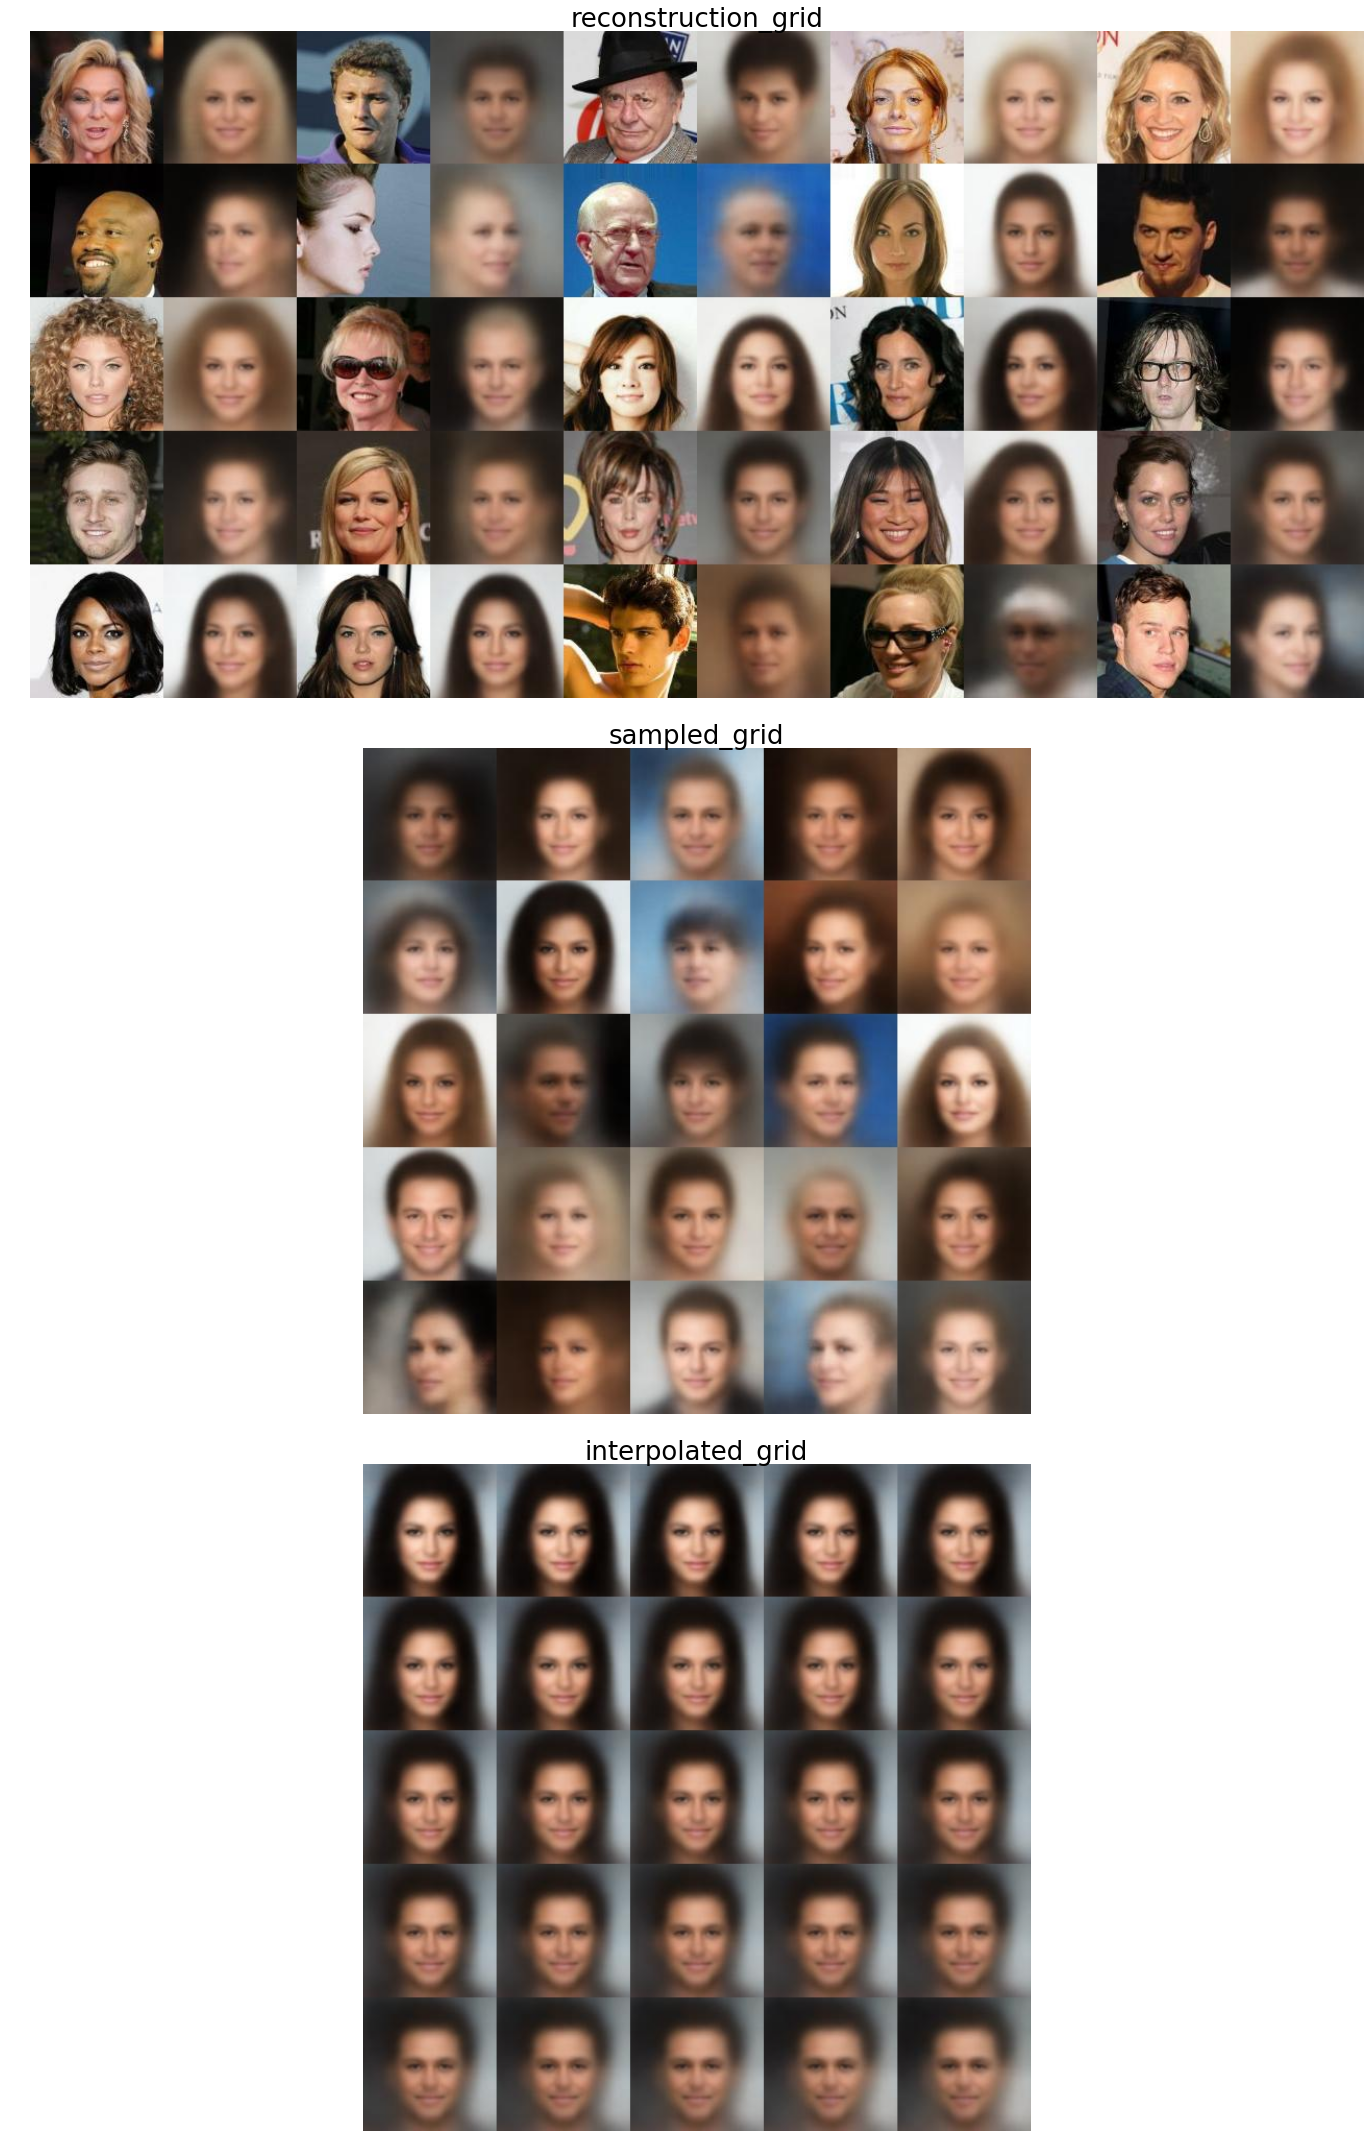

In [15]:
%matplotlib inline
# Plot
from matplotlib import pyplot as plt
image_dir = os.path.join(LOG_DIR, 'images')
max_indx = max([int(x.rsplit('.', 1)[0].rsplit('_', 1)[1])
                for x in glob.glob(os.path.join(image_dir, '*.jpg'))])
fig, axis = plt.subplots(len(SAVE_IMAGES_KEYS), 1, figsize=(19,30))
for i, k in enumerate(SAVE_IMAGES_KEYS):
    axis[i].set_axis_off()
    axis[i].set_title(k, fontsize=26)
    axis[i].imshow(scipy.misc.imread(os.path.join(image_dir, 
                                                  '%s_%d.jpg' % (k, max_indx))))
print(LOG_DIR)
print('Step %d' % max_indx)
fig.tight_layout()
plt.show()

Finally, we can search for the nearest neighbours of the generated images in the training set, to check for any potential overfitting problems (which does not seem to be the case here):

100000/100000

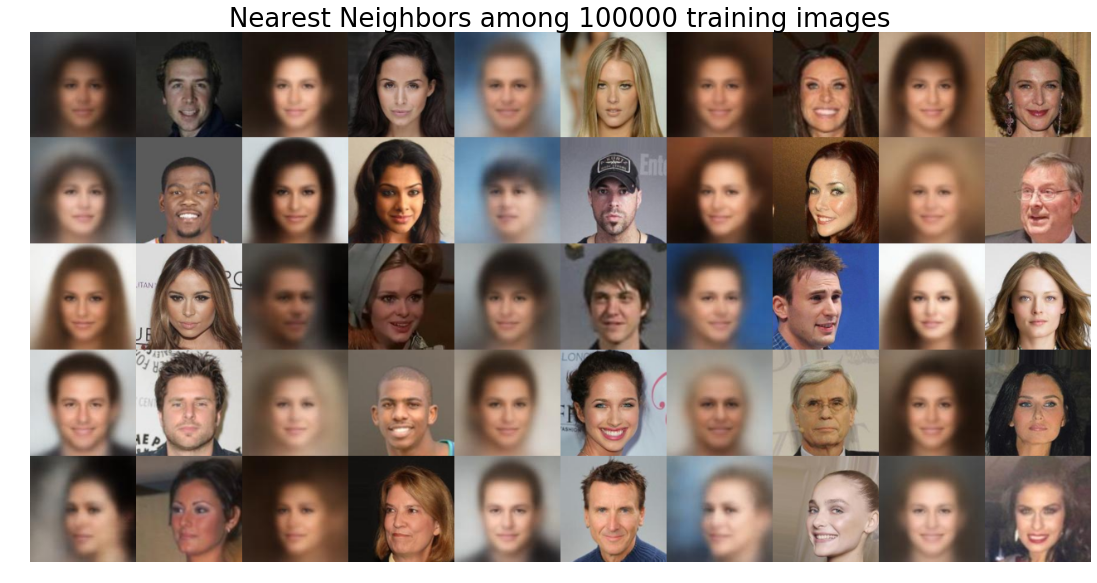

In [16]:
# Load samples
samples = scipy.misc.imread(os.path.join(image_dir, 'sampled_grid_%d.jpg' % max_indx)) / 255.
samples = [y_split for x_split in np.split(samples, NUM_ROWS, axis=0)
                   for y_split in np.split(x_split, NUM_ROWS, axis=1)]
samples = np.stack(samples, 0)
num_samples = samples.shape[0]
min_dists = np.ones((num_samples,))
nearest_neighbors = np.zeros_like(samples)

# Search for nearest neighbors among a certain number of images
num_images = 100000
image_files = glob.glob(os.path.join(BASE_DIR, '*.%s' % EXTENSION))[:num_images]
for i, image_file in enumerate(image_files):
    print('\r%d/%d' % (i + 1, len(image_files)), end='')
    # Preprocess image
    image = scipy.misc.imread(image_file)
    w, h, _ = image.shape
    min_side = 108 if TIGHT_CROP else min(w, h)
    offset_x = (w - min_side) // 2
    offset_y = (h - min_side) // 2
    image = image[offset_x:w - offset_x, offset_y:h - offset_y, :]
    image = scipy.misc.imresize(image, (SIZE, SIZE)) / 255.
    # Compare to samples (MSE)
    image = np.tile(np.expand_dims(image, 0), (num_samples, 1, 1, 1))
    dists = np.mean((image - samples)**2, axis=(1, 2, 3))
    min_indx = np.where(dists < min_dists)[0]
    # Update NNs
    nearest_neighbors[min_indx, ...] = image[min_indx, ...]
    min_dists[min_indx] = dists[min_indx]
    
# Grid view
out = np.concatenate([samples, nearest_neighbors], axis=1)
out = np.reshape(out, (2 * NUM_ROWS * NUM_ROWS, -1, SIZE, 3))
out = np.concatenate([x for x in out], axis=1)
out = np.split(out, NUM_ROWS, axis=1)
out = np.concatenate(out, axis=0)

# Imshow
fig, ax = plt.subplots(1, 1, figsize=(19, 12))
ax.set_axis_off()
ax.set_title('Nearest Neighbors among %d training images' % num_images, fontsize=26)
ax.imshow(out)
plt.show()